In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import json
from pprint import pprint

def save_fig(fig, name):
    fig.savefig("graphs/{}.png".format(name), format="png", dpi=500)
    fig.savefig("graphs/{}.pdf".format(name), format="pdf", dpi=500)

In [2]:
def load_json(path):
    with open(path) as f:
        data = json.load(f)
    timings = []
    for d in data["datapoints"]:
        s = d["setting"]
        comp = list(map(lambda x: (x["computationTime"]),
                       sorted(d["data"]["workers"], key=lambda x: x["rank"])))
        for time in comp:
            timings.append(time)
    return timings

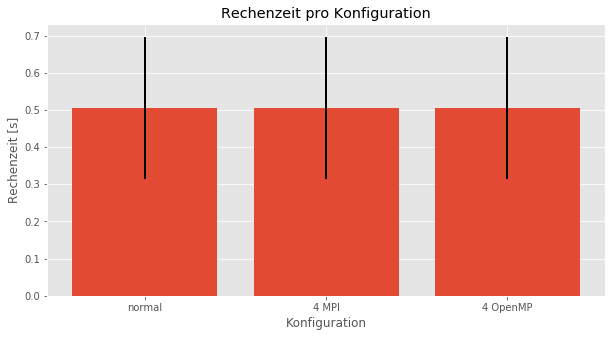

In [3]:
def barplot(x_data, y_data, error_data, x_label, y_label, x_ticks, title):
    fig, ax = plt.subplots(figsize=(10,5))
    bar = ax.bar(x_data, y_data, align='center')

    ax.errorbar(x_data, y_data, yerr=error_data, color='black', ls='none', lw = 2, capthick= 2)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

    ax.set_xticks(np.arange(len(x_ticks)))
    ax.set_xticklabels(x_ticks)

# timings in s
timings = np.asarray(load_json("./data_parallel_normal.json")) / 1e6
x = np.arange(3)
x_ticks = ["normal", "4 MPI", "4 OpenMP"]
y = (np.mean(timings), np.mean(timings), np.mean(timings))
yerr = (np.std(timings), np.std(timings), np.std(timings))

barplot(x, y, yerr, 
       x_label='Konfiguration',
       y_label='Rechenzeit [s]',
       x_ticks=x_ticks,
       title='Rechenzeit pro Konfiguration')

plt.show()
